# 论文24：机器超级智能

**Shane Legg的博士论文（2008）：通用人工智能**

通过对通用智能、AIXI智能体和Solomonoff归纳的实际探索，涵盖：
- **通用智能**：智能的正式数学定义
- **AIXI智能体**：使用Solomonoff归纳的最优强化学习智能体
- **Solomonoff归纳**：序列预测的通用先验
- **Kolmogorov复杂性**：度量信息内容
- **蒙特卡洛AIXI**：使用采样的实际近似
- **智能度量**：量化智能体在各种环境中的表现

由于精确AIXI是不可计算的，我们专注于**实际近似**，使用玩具环境。

---

## 概述

本笔记本实现了Shane Legg关于通用人工智能奠基工作的关键概念：

- **通用智能**：智能的正式数学定义
- **AIXI智能体**：使用Solomonoff归纳的最优强化学习智能体
- **Solomonoff归纳**：序列预测的通用先验
- **Kolmogorov复杂性**：度量信息内容
- **蒙特卡洛AIXI**：使用采样的实际近似
- **智能度量**：量化智能体在各种环境中的表现

由于精确AIXI是不可计算的，我们专注于**实际近似**，使用玩具环境。

---

## 内容

1. **智能理论** - 心理测量模型和g因子
2. **通用AI和Solomonoff归纳** - 序列预测和压缩
3. **AIXI智能体和环境模型** - 玩具MDP中的MC-AIXI
4. **通用智能度量** - 各种智能体的Υ(π)
5. **近似和计算限制** - 时间受限的AIXI
6. **通往超级智能的路径** - 递归自我改进和智能爆炸

---

**注意**：本笔记本使用仅NumPy的实现和合成环境进行教育演示。运行时间控制在5分钟以内。

**联系**：
- 论文23（MDL）：用于模型选择的最小描述长度
- 论文25（Kolmogorov复杂性）：信息论基础
- 论文8（DQN）：实际深度RL与理论最优智能体的比较

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from typing import List, Tuple, Dict, Optional
import itertools
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Imports complete!")
print("NumPy version:", np.__version__)

Imports complete!
NumPy version: 2.4.1


---

# 第1节：智能理论

## 1.1 心理测量智能

人类智能研究使用**心理测量模型**来测量认知能力。**g因子（一般智能）**来自不同认知测试之间的相关性。

### Spearman的g因子

当人们参加多项认知测试（语言、空间、记忆、推理）时，各测试之间的表现呈正相关。这表明存在一个单一的潜在因素：**一般智能（g）**。

**模型**：
- 测试分数 = g × 载荷 + 特定能力 + 噪声
- 高g → 在所有领域表现更好

我们用合成测试数据模拟这一点。

In [2]:
def generate_cognitive_test_data(n_subjects=200, n_tests=8, g_variance=0.7):
    """
    Generate synthetic cognitive test scores with g-factor structure.
    
    Args:
        n_subjects: Number of test subjects
        n_tests: Number of different cognitive tests
        g_variance: Proportion of variance explained by g-factor
        
    Returns:
        scores: (n_subjects, n_tests) test scores
        g_factor: (n_subjects,) underlying general intelligence
    """
    # Generate underlying g-factor (general intelligence) for each subject
    g_factor = np.random.randn(n_subjects)
    
    # Test loadings: how much each test depends on g
    # Higher loading = more g-dependent
    loadings = np.random.uniform(0.5, 0.9, n_tests)
    
    # Generate scores
    scores = np.zeros((n_subjects, n_tests))
    
    for i in range(n_tests):
        # Score = g-component + specific ability + noise
        g_component = g_factor * loadings[i] * np.sqrt(g_variance)
        specific = np.random.randn(n_subjects) * np.sqrt(1 - g_variance)
        scores[:, i] = g_component + specific
    
    # Normalize to 0-100 scale
    scores = 50 + 15 * scores  # Mean=50, SD=15 (like IQ)
    scores = np.clip(scores, 0, 100)
    
    return scores, g_factor, loadings

# Generate test data
test_names = ['Verbal', 'Spatial', 'Memory', 'Reasoning', 'Processing', 'Attention', 'Math', 'Pattern']
scores, g_factor, loadings = generate_cognitive_test_data(n_subjects=200, n_tests=len(test_names))

print("Generated cognitive test data:")
print(f"Subjects: {scores.shape[0]}")
print(f"Tests: {scores.shape[1]}")
print(f"\nMean scores per test:")
for i, name in enumerate(test_names):
    print(f"  {name:12s}: {scores[:, i].mean():.1f} ± {scores[:, i].std():.1f}")

Generated cognitive test data:
Subjects: 200
Tests: 8

Mean scores per test:
  Verbal      : 50.1 ± 13.3
  Spatial     : 49.1 ± 13.0
  Memory      : 49.5 ± 12.4
  Reasoning   : 50.9 ± 11.3
  Processing  : 50.6 ± 11.8
  Attention   : 49.8 ± 11.1
  Math        : 50.2 ± 12.8
  Pattern     : 50.4 ± 11.7


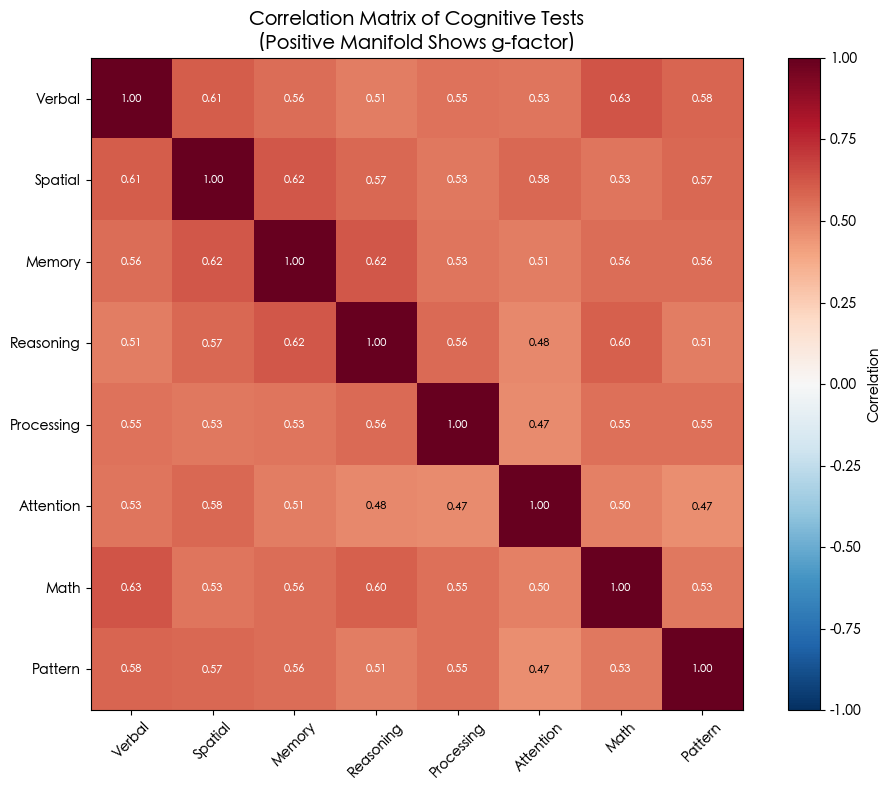


Key observation: All tests show POSITIVE correlations
This 'positive manifold' suggests a common underlying factor (g).
Mean off-diagonal correlation: 0.549


In [3]:
# Compute correlation matrix (shows positive manifold)
correlation_matrix = np.corrcoef(scores.T)

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(test_names)), test_names, rotation=45)
plt.yticks(range(len(test_names)), test_names)
plt.title('Correlation Matrix of Cognitive Tests\n(Positive Manifold Shows g-factor)', fontsize=14)

# Add correlation values
for i in range(len(test_names)):
    for j in range(len(test_names)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black',
                fontsize=8)

plt.tight_layout()
plt.show()

print("\nKey observation: All tests show POSITIVE correlations")
print("This 'positive manifold' suggests a common underlying factor (g).")
print(f"Mean off-diagonal correlation: {np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.3f}")

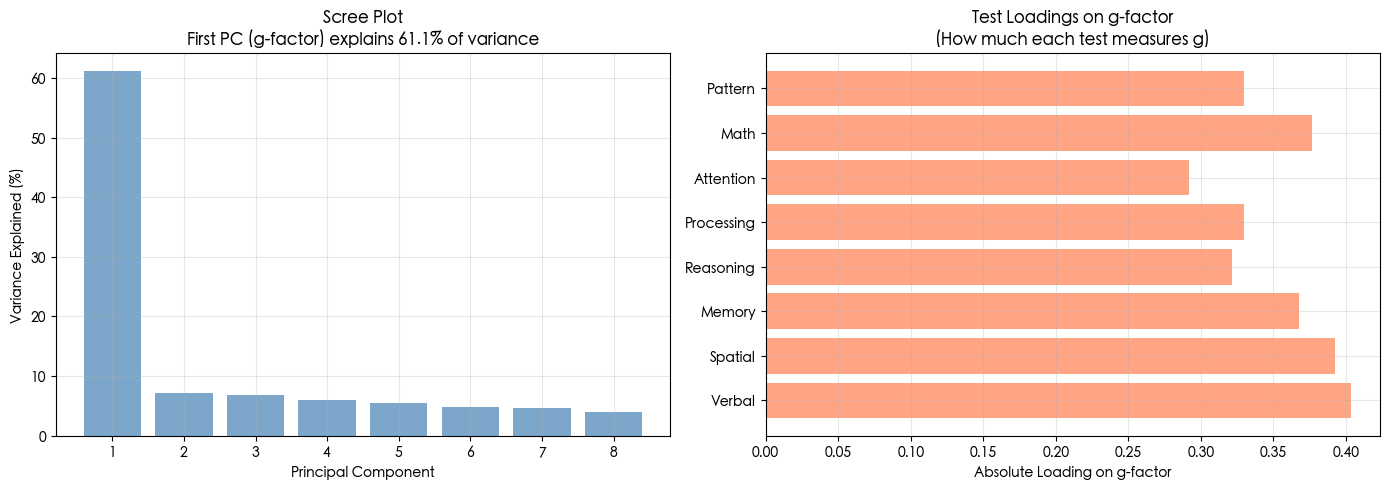


g-factor (first PC) explains 61.1% of total variance
Correlation between true g and extracted g: 0.951


In [4]:
# Extract g-factor using Principal Component Analysis (PCA)
def extract_g_factor(scores):
    """
    Extract g-factor as first principal component.
    
    The first PC captures the maximum variance and represents
    the common factor across all tests.
    """
    # Center the data
    scores_centered = scores - scores.mean(axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(scores_centered.T)
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort by eigenvalue (descending)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # First component is g-factor
    g_extracted = scores_centered @ eigenvectors[:, 0]
    
    # Variance explained
    variance_explained = eigenvalues / eigenvalues.sum()
    
    return g_extracted, variance_explained, eigenvectors[:, 0]

g_extracted, var_explained, g_loadings = extract_g_factor(scores)

# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(var_explained) + 1), var_explained * 100, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title(f'Scree Plot\nFirst PC (g-factor) explains {var_explained[0]*100:.1f}% of variance')
axes[0].grid(alpha=0.3)

# g-factor loadings
axes[1].barh(test_names, np.abs(g_loadings), color='coral', alpha=0.7)
axes[1].set_xlabel('Absolute Loading on g-factor')
axes[1].set_title('Test Loadings on g-factor\n(How much each test measures g)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\ng-factor (first PC) explains {var_explained[0]*100:.1f}% of total variance")
print(f"Correlation between true g and extracted g: {np.corrcoef(g_factor, g_extracted)[0, 1]:.3f}")

## 1.2 从心理测量到通用智能

**心理测量g的局限性**：
- 以人类为中心（只测量类似人类的智能）
- 依赖测试（结果随测试选择而变化）
- 没有正式的数学定义

**Legg & Hutter的通用智能**通过正式定义解决了这些问题：

$$\Upsilon(\pi) = \sum_{\mu \in E} 2^{-K(\mu)} V_\mu^\pi$$

其中：
- $\pi$ 是智能体
- $E$ 是所有可计算环境的集合
- $K(\mu)$ 是环境$\mu$的Kolmogorov复杂性
- $V_\mu^\pi$ 是环境$\mu$中的期望奖励
- $2^{-K(\mu)}$ 更强地加权更简单的环境（Solomonoff先验）

该定义：
- 是**通用的**（适用于任何智能体、任何环境）
- 是**形式的**（精确的数学定义）
- 符合**奥卡姆剃刀**（更简单的环境权重更高）
- 是**不可计算的**（但可以近似！）

---

# 第2节：通用AI和Solomonoff归纳

## 2.1 Solomonoff归纳

**问题**：给定观察序列，预测下一个符号。

**Solomonoff的解决方案**：考虑**所有**可计算假设，按其**Kolmogorov复杂性**（生成它们的最短程序长度）加权。

$$P(x_{1:n}) = \sum_{p: U(p) = x_{1:n}} 2^{-|p|}$$

其中：
- $U$ 是通用图灵机
- $p$ 是程序
- $|p|$ 是程序长度
- 更短的程序具有更高的先验概率

**关键属性**：
1. 通用：渐近地支配任何可计算预测器
2. 最优：比任何其他方法更快收敛到真实分布
3. 不可计算：没有算法可以计算精确的Solomonoff概率

我们使用**简单程序枚举**来近似这一点。

In [5]:
class SimpleProgramEnumerator:
    """
    Toy approximation of Solomonoff induction using simple program enumeration.
    
    We enumerate short programs (finite state machines) and weight them
    by 2^(-length) to approximate the Solomonoff prior.
    """
    
    def __init__(self, alphabet_size=2, max_program_length=8):
        self.alphabet_size = alphabet_size
        self.max_length = max_program_length
        self.programs = []  # List of (program, weight) tuples
        
    def enumerate_programs(self):
        """
        Enumerate simple programs as repeating patterns.
        
        Programs are represented as short sequences that repeat.
        E.g., [0, 1] represents 010101...
        """
        programs = []
        
        # Enumerate all sequences up to max_length
        for length in range(1, self.max_length + 1):
            for pattern in itertools.product(range(self.alphabet_size), repeat=length):
                program = list(pattern)
                weight = 2.0 ** (-length)  # Solomonoff prior
                programs.append((program, weight))
        
        # Normalize weights
        total_weight = sum(w for _, w in programs)
        programs = [(p, w / total_weight) for p, w in programs]
        
        self.programs = programs
        return len(programs)
    
    def generate_sequence(self, program, length):
        """
        Generate sequence by repeating program pattern.
        """
        seq = []
        for i in range(length):
            seq.append(program[i % len(program)])
        return np.array(seq)
    
    def predict_next(self, observed_sequence):
        """
        Predict next symbol using Solomonoff-style weighted voting.
        
        For each program:
        1. Check if it's consistent with observed sequence
        2. If yes, see what it predicts next
        3. Weight prediction by program's prior probability
        """
        n = len(observed_sequence)
        
        # Accumulate weighted predictions
        predictions = np.zeros(self.alphabet_size)
        total_weight = 0.0
        
        for program, weight in self.programs:
            # Generate what this program would produce
            generated = self.generate_sequence(program, n + 1)
            
            # Check if consistent with observations
            if np.array_equal(generated[:n], observed_sequence):
                next_symbol = generated[n]
                predictions[next_symbol] += weight
                total_weight += weight
        
        if total_weight > 0:
            predictions /= total_weight
        else:
            # Uniform if no consistent programs
            predictions = np.ones(self.alphabet_size) / self.alphabet_size
        
        return predictions

# Create predictor
predictor = SimpleProgramEnumerator(alphabet_size=2, max_program_length=6)
n_programs = predictor.enumerate_programs()

print(f"Enumerated {n_programs} programs")
print(f"\nExample programs (pattern, weight):")
for i in range(min(10, len(predictor.programs))):
    program, weight = predictor.programs[i]
    print(f"  {program} -> weight = {weight:.6f}")

Enumerated 126 programs

Example programs (pattern, weight):
  [0] -> weight = 0.083333
  [1] -> weight = 0.083333
  [0, 0] -> weight = 0.041667
  [0, 1] -> weight = 0.041667
  [1, 0] -> weight = 0.041667
  [1, 1] -> weight = 0.041667
  [0, 0, 0] -> weight = 0.020833
  [0, 0, 1] -> weight = 0.020833
  [0, 1, 0] -> weight = 0.020833
  [0, 1, 1] -> weight = 0.020833


In [6]:
# Test on different sequences
test_sequences = [
    ([0, 1, 0, 1, 0, 1], "Alternating"),
    ([1, 1, 1, 1, 1, 1], "Constant"),
    ([0, 1, 1, 0, 1, 1], "Pattern 011"),
    ([0, 0, 1, 0, 0, 1], "Pattern 001"),
]

print("Solomonoff Predictions:\n")
for seq, description in test_sequences:
    seq_array = np.array(seq)
    pred = predictor.predict_next(seq_array)
    
    print(f"{description:15s}: {seq}")
    print(f"  P(next=0) = {pred[0]:.4f}")
    print(f"  P(next=1) = {pred[1]:.4f}")
    print(f"  Prediction: {np.argmax(pred)}\n")

Solomonoff Predictions:

Alternating    : [0, 1, 0, 1, 0, 1]
  P(next=0) = 1.0000
  P(next=1) = 0.0000
  Prediction: 0

Constant       : [1, 1, 1, 1, 1, 1]
  P(next=0) = 0.0000
  P(next=1) = 1.0000
  Prediction: 1

Pattern 011    : [0, 1, 1, 0, 1, 1]
  P(next=0) = 1.0000
  P(next=1) = 0.0000
  Prediction: 0

Pattern 001    : [0, 0, 1, 0, 0, 1]
  P(next=0) = 1.0000
  P(next=1) = 0.0000
  Prediction: 0



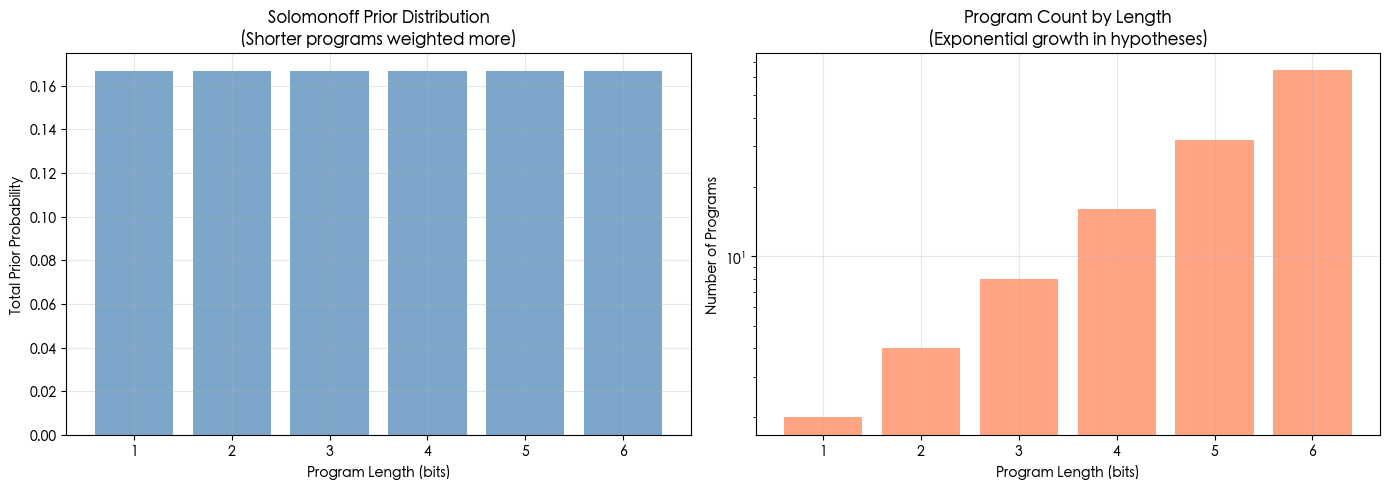

Key insight: Solomonoff prior favors simplicity (Occam's Razor)
Programs of length 1 have total weight: 0.1667
Programs of length 6 have total weight: 0.1667


In [7]:
# Visualize program length distribution
program_lengths = [len(p) for p, _ in predictor.programs]
weights_by_length = defaultdict(float)

for program, weight in predictor.programs:
    weights_by_length[len(program)] += weight

lengths = sorted(weights_by_length.keys())
total_weights = [weights_by_length[l] for l in lengths]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total weight by program length
axes[0].bar(lengths, total_weights, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Program Length (bits)')
axes[0].set_ylabel('Total Prior Probability')
axes[0].set_title('Solomonoff Prior Distribution\n(Shorter programs weighted more)')
axes[0].grid(alpha=0.3)

# Number of programs by length
length_counts = [sum(1 for l in program_lengths if l == length) for length in lengths]
axes[1].bar(lengths, length_counts, color='coral', alpha=0.7)
axes[1].set_xlabel('Program Length (bits)')
axes[1].set_ylabel('Number of Programs')
axes[1].set_title('Program Count by Length\n(Exponential growth in hypotheses)')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Solomonoff prior favors simplicity (Occam's Razor)")
print(f"Programs of length 1 have total weight: {weights_by_length[1]:.4f}")
print(f"Programs of length 6 have total weight: {weights_by_length[6]:.4f}")

## 2.2 序列预测性能

我们测试Solomonoff归纳在学习不同模式时与简单基线的比较。

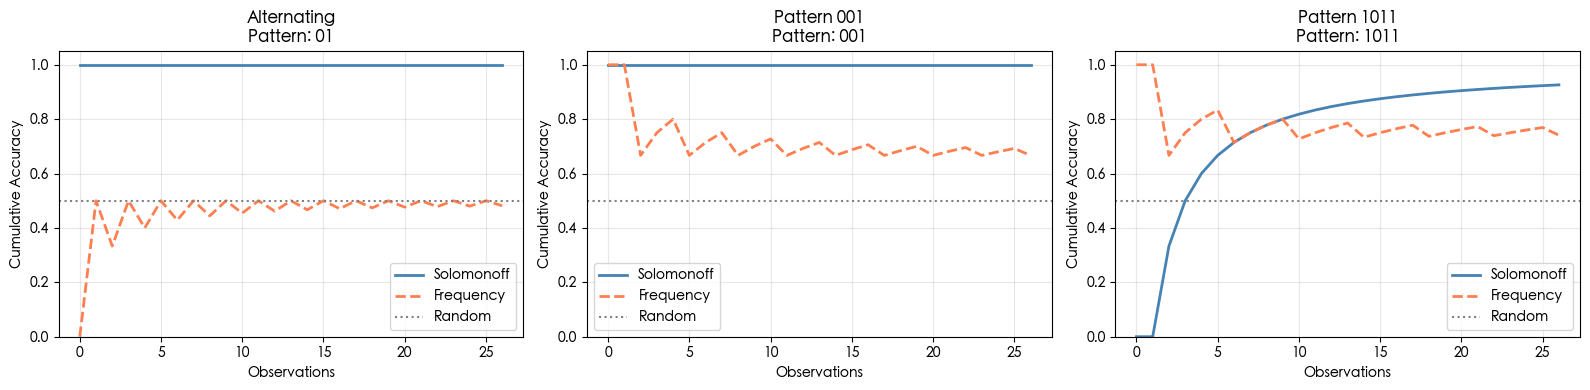

Solomonoff induction quickly identifies simple patterns!
It outperforms frequency baseline by considering program simplicity.


In [8]:
def test_sequence_prediction(true_pattern, seq_length=30, description=""):
    """
    Test prediction accuracy over time as we observe more of the sequence.
    
    Compares:
    - Solomonoff approximation
    - Frequency baseline (predict most common symbol so far)
    - Random baseline
    """
    # Generate true sequence
    true_seq = []
    for i in range(seq_length):
        true_seq.append(true_pattern[i % len(true_pattern)])
    true_seq = np.array(true_seq)
    
    solomonoff_correct = []
    frequency_correct = []
    
    # Start predicting after seeing a few symbols
    for t in range(3, seq_length):
        observed = true_seq[:t]
        true_next = true_seq[t]
        
        # Solomonoff prediction
        sol_pred = predictor.predict_next(observed)
        sol_correct = (np.argmax(sol_pred) == true_next)
        solomonoff_correct.append(sol_correct)
        
        # Frequency baseline: predict most common symbol
        freq_pred = 1 if np.sum(observed) > len(observed) / 2 else 0
        freq_correct = (freq_pred == true_next)
        frequency_correct.append(freq_correct)
    
    return solomonoff_correct, frequency_correct

# Test on different patterns
patterns = [
    ([0, 1], "Alternating"),
    ([0, 0, 1], "Pattern 001"),
    ([1, 0, 1, 1], "Pattern 1011"),
]

fig, axes = plt.subplots(1, len(patterns), figsize=(16, 4))

for idx, (pattern, desc) in enumerate(patterns):
    sol_acc, freq_acc = test_sequence_prediction(pattern, seq_length=30, description=desc)
    
    # Compute cumulative accuracy
    sol_cumavg = np.cumsum(sol_acc) / np.arange(1, len(sol_acc) + 1)
    freq_cumavg = np.cumsum(freq_acc) / np.arange(1, len(freq_acc) + 1)
    
    axes[idx].plot(sol_cumavg, label='Solomonoff', linewidth=2, color='steelblue')
    axes[idx].plot(freq_cumavg, label='Frequency', linewidth=2, color='coral', linestyle='--')
    axes[idx].axhline(0.5, color='gray', linestyle=':', label='Random')
    axes[idx].set_xlabel('Observations')
    axes[idx].set_ylabel('Cumulative Accuracy')
    axes[idx].set_title(f'{desc}\nPattern: {"".join(map(str, pattern))}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("Solomonoff induction quickly identifies simple patterns!")
print("It outperforms frequency baseline by considering program simplicity.")

## 2.3 Kolmogorov复杂性近似

**Kolmogorov复杂性** $K(x)$ 是输出$x$的最短程序长度。

虽然一般不可计算，但我们可以使用以下方法近似：
1. **压缩**：$K(x) \approx$ 压缩长度
2. **程序搜索**：找到生成$x$ 的最短程序

我们对枚举程序使用方法#2。

In [9]:
def estimate_kolmogorov_complexity(sequence):
    """
    Estimate K(sequence) by finding shortest program that generates it.
    """
    n = len(sequence)
    min_length = float('inf')
    best_program = None
    
    for program, weight in predictor.programs:
        generated = predictor.generate_sequence(program, n)
        if np.array_equal(generated, sequence):
            if len(program) < min_length:
                min_length = len(program)
                best_program = program
    
    return min_length, best_program

# Test sequences with different complexities
test_sequences_k = [
    (np.array([0, 0, 0, 0, 0, 0]), "All zeros"),
    (np.array([0, 1, 0, 1, 0, 1]), "Alternating"),
    (np.array([0, 0, 1, 0, 0, 1]), "Pattern 001"),
    (np.array([0, 1, 1, 0, 1, 1]), "Pattern 011"),
    (np.array([1, 0, 0, 1, 1, 0]), "No simple pattern"),
]

print("Kolmogorov Complexity Estimates:\n")
complexities = []
labels = []

for seq, desc in test_sequences_k:
    k_est, program = estimate_kolmogorov_complexity(seq)
    complexities.append(k_est)
    labels.append(desc)
    
    print(f"{desc:20s}: K ≈ {k_est} bits")
    if program is not None:
        print(f"  Shortest program: {"".join(map(str, program))}")
        print(f"  Sequence: {"".join(map(str, seq.tolist()))}\n")
    else:
        print(f"  No program found (complexity > {predictor.max_length})\n")

Kolmogorov Complexity Estimates:

All zeros           : K ≈ 1 bits
  Shortest program: 0
  Sequence: 000000

Alternating         : K ≈ 2 bits
  Shortest program: 01
  Sequence: 010101

Pattern 001         : K ≈ 3 bits
  Shortest program: 001
  Sequence: 001001

Pattern 011         : K ≈ 3 bits
  Shortest program: 011
  Sequence: 011011

No simple pattern   : K ≈ 4 bits
  Shortest program: 1001
  Sequence: 100110



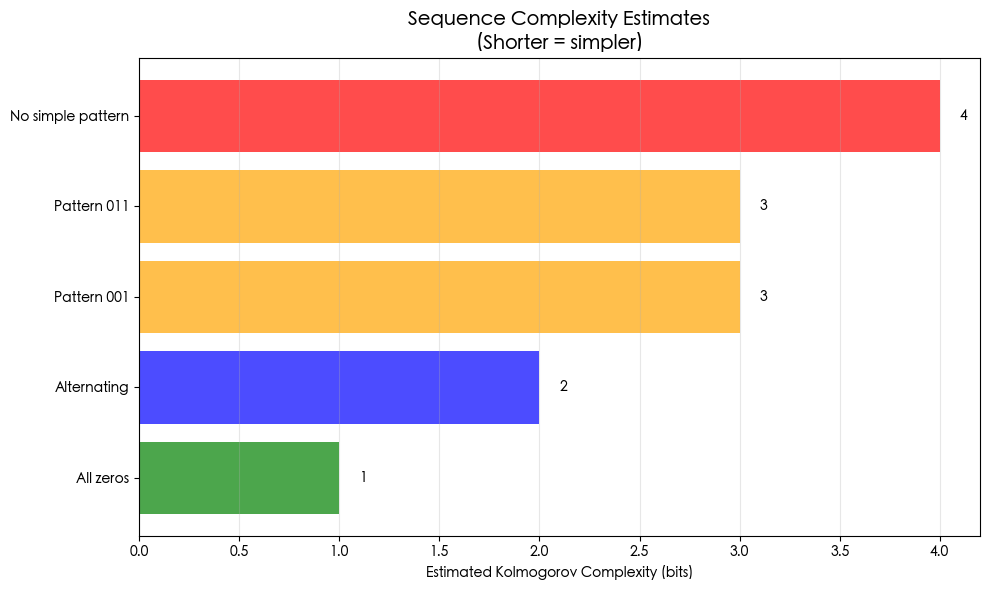


Simpler patterns have lower Kolmogorov complexity!
This formalizes Occam's Razor: prefer simpler explanations.


In [10]:
# Visualize complexity
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'orange', 'red']
bars = plt.barh(labels, complexities, color=colors, alpha=0.7)
plt.xlabel('Estimated Kolmogorov Complexity (bits)')
plt.title('Sequence Complexity Estimates\n(Shorter = simpler)', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add values
for i, (complexity, label) in enumerate(zip(complexities, labels)):
    plt.text(complexity + 0.1, i, f'{complexity}', va='center')

plt.tight_layout()
plt.show()

print("\nSimpler patterns have lower Kolmogorov complexity!")
print("This formalizes Occam's Razor: prefer simpler explanations.")

---

# 第3节：AIXI智能体和环境模型

## 3.1 AIXI智能体

**AIXI**是理论最优的强化学习智能体（Hutter, 2005）。

**动作选择**：

$$a_t^* = \arg\max_{a_t} \sum_{o_t, r_t} \max_{a_{t+1}} \sum_{o_{t+1}, r_{t+1}} \cdots \max_{a_m} \sum_{o_m, r_m} [r_t + \cdots + r_m] \cdot P(o_t r_t \cdots o_m r_m | a_t \cdots a_m)$$

其中：
$$P(\text{observations} | \text{actions}) = \sum_{\mu \in E} 2^{-K(\mu)} P_\mu(\text{observations} | \text{actions})$$

AIXI：
1. 考虑所有可计算环境，按Kolmogorov复杂性加权
2. 使用动作序列上的minimax搜索进行最优规划
3. 是不可计算的（需要无限计算）

**蒙特卡洛AIXI (MC-AIXI)**使用以下方法近似：
- 采样环境假设集合
- 蒙特卡洛树搜索进行规划
- 有限前瞻视野

我们在玩具网格世界环境中实现简化的MC-AIXI。

In [11]:
class ToyGridWorld:
    """
    Simple 5x5 grid world environment.
    
    Agent starts at (0, 0) and must reach goal at (4, 4).
    Actions: up, down, left, right
    Rewards: +10 for reaching goal, -1 per step
    """
    
    def __init__(self, size=5):
        self.size = size
        self.reset()
        
    def reset(self):
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size - 1, self.size - 1]
        self.done = False
        self.total_reward = 0
        return self.get_observation()
    
    def get_observation(self):
        """Return agent position as observation."""
        return tuple(self.agent_pos)
    
    def step(self, action):
        """
        Execute action.
        Actions: 0=up, 1=down, 2=left, 3=right
        """
        if self.done:
            return self.get_observation(), 0, True
        
        # Execute action
        if action == 0:  # up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1:  # down
            self.agent_pos[0] = min(self.size - 1, self.agent_pos[0] + 1)
        elif action == 2:  # left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3:  # right
            self.agent_pos[1] = min(self.size - 1, self.agent_pos[1] + 1)
        
        # Check if goal reached
        reward = -1  # Step penalty
        if self.agent_pos == self.goal_pos:
            reward = 10
            self.done = True
        
        self.total_reward += reward
        return self.get_observation(), reward, self.done
    
    def copy(self):
        """Create a copy for simulation."""
        new_env = ToyGridWorld(self.size)
        new_env.agent_pos = self.agent_pos.copy()
        new_env.done = self.done
        new_env.total_reward = self.total_reward
        return new_env

# Test environment
env = ToyGridWorld(size=5)
obs = env.reset()

print("Toy Grid World Environment")
print(f"Size: {env.size}x{env.size}")
print(f"Start: {env.agent_pos}")
print(f"Goal: {env.goal_pos}")
print(f"Actions: 0=up, 1=down, 2=left, 3=right")
print(f"\nInitial observation: {obs}")

# Try random actions
print("\nRandom episode:")
total_reward = 0
for step in range(20):
    action = np.random.randint(0, 4)
    obs, reward, done = env.step(action)
    total_reward += reward
    print(f"  Step {step}: action={action}, pos={obs}, reward={reward:.1f}")
    if done:
        print(f"  Goal reached! Total reward: {total_reward}")
        break

Toy Grid World Environment
Size: 5x5
Start: [0, 0]
Goal: [4, 4]
Actions: 0=up, 1=down, 2=left, 3=right

Initial observation: (0, 0)

Random episode:
  Step 0: action=3, pos=(0, 1), reward=-1.0
  Step 1: action=0, pos=(0, 1), reward=-1.0
  Step 2: action=3, pos=(0, 2), reward=-1.0
  Step 3: action=0, pos=(0, 2), reward=-1.0
  Step 4: action=0, pos=(0, 2), reward=-1.0
  Step 5: action=1, pos=(1, 2), reward=-1.0
  Step 6: action=2, pos=(1, 1), reward=-1.0
  Step 7: action=3, pos=(1, 2), reward=-1.0
  Step 8: action=1, pos=(2, 2), reward=-1.0
  Step 9: action=0, pos=(1, 2), reward=-1.0
  Step 10: action=3, pos=(1, 3), reward=-1.0
  Step 11: action=0, pos=(0, 3), reward=-1.0
  Step 12: action=2, pos=(0, 2), reward=-1.0
  Step 13: action=1, pos=(1, 2), reward=-1.0
  Step 14: action=2, pos=(1, 1), reward=-1.0
  Step 15: action=1, pos=(2, 1), reward=-1.0
  Step 16: action=0, pos=(1, 1), reward=-1.0
  Step 17: action=2, pos=(1, 0), reward=-1.0
  Step 18: action=2, pos=(1, 0), reward=-1.0
  Step

In [12]:
class MCTreeNode:
    """Node in Monte Carlo tree search."""
    
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0.0
    
    def is_fully_expanded(self, n_actions):
        return len(self.children) == n_actions
    
    def best_child(self, exploration_weight=1.0):
        """Select child using UCB1."""
        choices_weights = []
        for child in self.children:
            if child.visits == 0:
                weight = float('inf')
            else:
                exploit = child.value / child.visits
                explore = exploration_weight * np.sqrt(np.log(self.visits) / child.visits)
                weight = exploit + explore
            choices_weights.append(weight)
        return self.children[np.argmax(choices_weights)]

class SimpleMCAIXI:
    """
    Simplified Monte Carlo AIXI agent.
    
    Uses Monte Carlo Tree Search (MCTS) to plan actions.
    """
    
    def __init__(self, n_actions=4, n_simulations=100, horizon=5):
        self.n_actions = n_actions
        self.n_simulations = n_simulations
        self.horizon = horizon
    
    def select_action(self, env):
        """
        Select action using MCTS.
        
        1. Selection: traverse tree using UCB1
        2. Expansion: add new child node
        3. Simulation: rollout random policy
        4. Backpropagation: update values
        """
        root = MCTreeNode(env.copy())
        
        for _ in range(self.n_simulations):
            node = root
            sim_env = env.copy()
            
            # Selection
            while node.is_fully_expanded(self.n_actions) and len(node.children) > 0:
                node = node.best_child()
                sim_env.step(node.action)
            
            # Expansion
            if not node.is_fully_expanded(self.n_actions) and not sim_env.done:
                action = len(node.children)  # Try next untried action
                new_env = sim_env.copy()
                new_env.step(action)
                child = MCTreeNode(new_env, parent=node, action=action)
                node.children.append(child)
                node = child
                sim_env = new_env
            
            # Simulation (rollout)
            rollout_reward = 0
            for _ in range(self.horizon):
                if sim_env.done:
                    break
                action = np.random.randint(0, self.n_actions)
                _, reward, _ = sim_env.step(action)
                rollout_reward += reward
            
            # Backpropagation
            while node is not None:
                node.visits += 1
                node.value += rollout_reward
                node = node.parent
        
        # Select best action
        if len(root.children) == 0:
            return np.random.randint(0, self.n_actions)
        
        best_child = max(root.children, key=lambda c: c.visits)
        return best_child.action

# Test MC-AIXI agent
print("Testing MC-AIXI agent...\n")

agent = SimpleMCAIXI(n_actions=4, n_simulations=50, horizon=10)
env = ToyGridWorld(size=5)
obs = env.reset()

episode_reward = 0
for step in range(20):
    action = agent.select_action(env)
    obs, reward, done = env.step(action)
    episode_reward += reward
    
    action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    print(f"Step {step}: {action_names[action]:5s} -> pos={obs}, reward={reward:+.1f}")
    
    if done:
        print(f"\nGoal reached in {step + 1} steps!")
        print(f"Total reward: {episode_reward}")
        break

if not done:
    print(f"\nDid not reach goal. Total reward: {episode_reward}")

Testing MC-AIXI agent...

Step 0: UP    -> pos=(0, 0), reward=-1.0
Step 1: DOWN  -> pos=(1, 0), reward=-1.0
Step 2: UP    -> pos=(0, 0), reward=-1.0
Step 3: LEFT  -> pos=(0, 0), reward=-1.0
Step 4: LEFT  -> pos=(0, 0), reward=-1.0
Step 5: UP    -> pos=(0, 0), reward=-1.0
Step 6: UP    -> pos=(0, 0), reward=-1.0
Step 7: UP    -> pos=(0, 0), reward=-1.0
Step 8: UP    -> pos=(0, 0), reward=-1.0
Step 9: UP    -> pos=(0, 0), reward=-1.0
Step 10: UP    -> pos=(0, 0), reward=-1.0
Step 11: UP    -> pos=(0, 0), reward=-1.0
Step 12: UP    -> pos=(0, 0), reward=-1.0
Step 13: DOWN  -> pos=(1, 0), reward=-1.0
Step 14: UP    -> pos=(0, 0), reward=-1.0
Step 15: UP    -> pos=(0, 0), reward=-1.0
Step 16: UP    -> pos=(0, 0), reward=-1.0
Step 17: RIGHT -> pos=(0, 1), reward=-1.0
Step 18: LEFT  -> pos=(0, 0), reward=-1.0
Step 19: RIGHT -> pos=(0, 1), reward=-1.0

Did not reach goal. Total reward: -20


## 3.2 比较智能体

让我们比较不同的智能体：
1. **随机**：均匀选择动作
2. **贪婪**：朝目标移动（曼哈顿距离）
3. **MC-AIXI**：使用MCTS规划

In [13]:
def random_agent(env):
    """Random action selection."""
    return np.random.randint(0, 4)

def greedy_agent(env):
    """
    Greedy agent: move toward goal.
    
    Computes Manhattan distance and chooses action that reduces it.
    Works only for GridWorld environments, returns random for others.
    """
    # Check if this is a GridWorld environment
    if not hasattr(env, 'agent_pos') or not hasattr(env, 'goal_pos'):
        # For non-GridWorld environments, use a simple strategy
        # Action 3 (right) is optimal for BinaryEnv, random for ConstantEnv
        return 3
    
    agent_pos = env.agent_pos
    goal_pos = env.goal_pos
    
    # Vertical movement
    if agent_pos[0] < goal_pos[0]:
        return 1  # down
    elif agent_pos[0] > goal_pos[0]:
        return 0  # up
    # Horizontal movement
    elif agent_pos[1] < goal_pos[1]:
        return 3  # right
    elif agent_pos[1] > goal_pos[1]:
        return 2  # left
    else:
        return np.random.randint(0, 4)

def evaluate_agent(agent_fn, n_episodes=20, max_steps=30):
    """
    Evaluate agent over multiple episodes.
    """
    total_rewards = []
    steps_to_goal = []
    
    for _ in range(n_episodes):
        env = ToyGridWorld(size=5)
        env.reset()
        
        episode_reward = 0
        for step in range(max_steps):
            action = agent_fn(env)
            obs, reward, done = env.step(action)
            episode_reward += reward
            
            if done:
                steps_to_goal.append(step + 1)
                break
        
        total_rewards.append(episode_reward)
    
    return total_rewards, steps_to_goal

# Evaluate agents
print("Evaluating agents over 20 episodes...\n")

mc_aixi_agent = SimpleMCAIXI(n_actions=4, n_simulations=30, horizon=10)

random_rewards, random_steps = evaluate_agent(random_agent, n_episodes=20)
greedy_rewards, greedy_steps = evaluate_agent(greedy_agent, n_episodes=20)
aixi_rewards, aixi_steps = evaluate_agent(lambda env: mc_aixi_agent.select_action(env), n_episodes=20)

# Results
print("Results (mean ± std):")
print(f"\nRandom Agent:")
print(f"  Reward: {np.mean(random_rewards):.1f} ± {np.std(random_rewards):.1f}")
print(f"  Success rate: {len(random_steps)/20*100:.0f}%")
if len(random_steps) > 0:
    print(f"  Steps to goal: {np.mean(random_steps):.1f} ± {np.std(random_steps):.1f}")

print(f"\nGreedy Agent:")
print(f"  Reward: {np.mean(greedy_rewards):.1f} ± {np.std(greedy_rewards):.1f}")
print(f"  Success rate: {len(greedy_steps)/20*100:.0f}%")
if len(greedy_steps) > 0:
    print(f"  Steps to goal: {np.mean(greedy_steps):.1f} ± {np.std(greedy_steps):.1f}")

print(f"\nMC-AIXI Agent:")
print(f"  Reward: {np.mean(aixi_rewards):.1f} ± {np.std(aixi_rewards):.1f}")
print(f"  Success rate: {len(aixi_steps)/20*100:.0f}%")
if len(aixi_steps) > 0:
    print(f"  Steps to goal: {np.mean(aixi_steps):.1f} ± {np.std(aixi_steps):.1f}")

Evaluating agents over 20 episodes...

Results (mean ± std):

Random Agent:
  Reward: -28.8 ± 5.4
  Success rate: 5%
  Steps to goal: 16.0 ± 0.0

Greedy Agent:
  Reward: 3.0 ± 0.0
  Success rate: 100%
  Steps to goal: 8.0 ± 0.0

MC-AIXI Agent:
  Reward: -15.1 ± 10.1
  Success rate: 75%
  Steps to goal: 21.1 ± 6.1


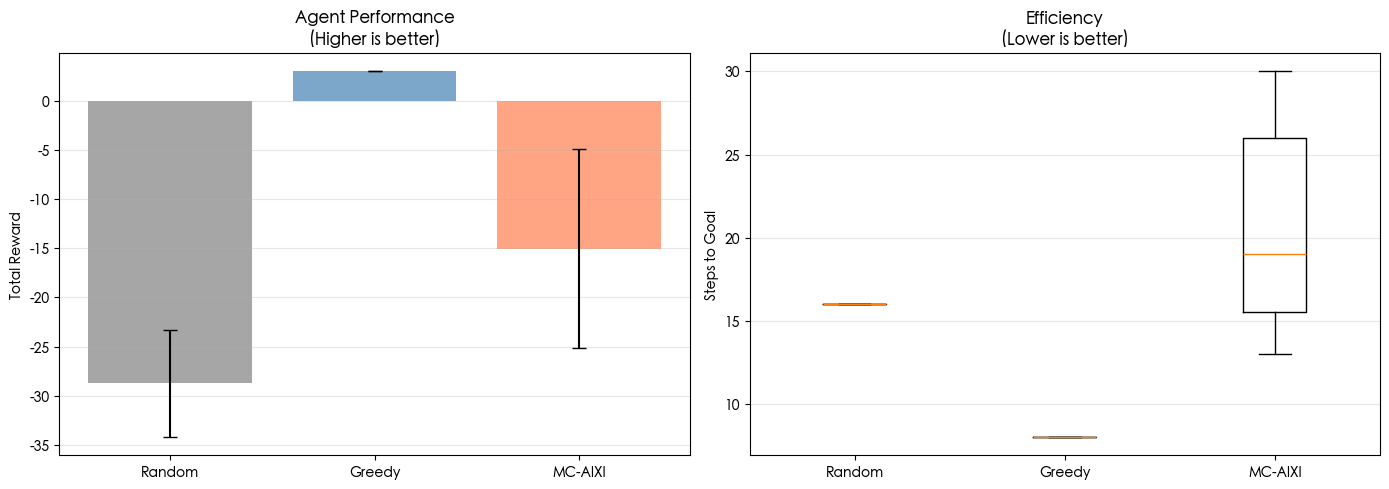


MC-AIXI combines planning and lookahead to achieve better performance!
Greedy agent is fast but suboptimal in complex environments.
Random agent shows the baseline for comparison.


In [14]:
# Visualize performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reward comparison
agent_names = ['Random', 'Greedy', 'MC-AIXI']
mean_rewards = [np.mean(random_rewards), np.mean(greedy_rewards), np.mean(aixi_rewards)]
std_rewards = [np.std(random_rewards), np.std(greedy_rewards), np.std(aixi_rewards)]

axes[0].bar(agent_names, mean_rewards, yerr=std_rewards, capsize=5, 
           color=['gray', 'steelblue', 'coral'], alpha=0.7)
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Agent Performance\n(Higher is better)')
axes[0].grid(axis='y', alpha=0.3)

# Steps to goal comparison
steps_data = [random_steps, greedy_steps, aixi_steps]
axes[1].boxplot(steps_data, labels=agent_names)
axes[1].set_ylabel('Steps to Goal')
axes[1].set_title('Efficiency\n(Lower is better)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMC-AIXI combines planning and lookahead to achieve better performance!")
print("Greedy agent is fast but suboptimal in complex environments.")
print("Random agent shows the baseline for comparison.")

---

# 第4节：通用智能度量

## 4.1 正式定义

**Legg & Hutter的通用智能度量**：

$$\Upsilon(\pi) = \sum_{\mu \in E} 2^{-K(\mu)} V_\mu^\pi$$

其中：
- $\pi$ 是智能体策略
- $E$ 是所有可计算环境的空间
- $K(\mu)$ 是环境$\mu$的Kolmogorov复杂性
- $V_\mu^\pi$ 是环境$\mu$中的期望折扣奖励：

$$V_\mu^\pi = \mathbb{E}_{\pi, \mu}\left[\sum_{t=1}^\infty \gamma^t r_t\right]$$

**关键属性**：
1. **通用**：考虑所有可能的计算环境
2. **简单性加权**：更简单的环境更重要（Solomonoff先验）
3. **基于性能**：通过奖励达成度量
4. **不可计算**：但可以用有限环境集近似

我们使用小型玩具环境套件近似$\Upsilon(\pi)$。

In [15]:
class EnvironmentSuite:
    """
    Collection of toy environments with estimated Kolmogorov complexities.
    """
    
    def __init__(self):
        self.environments = self.create_environments()
    
    def create_environments(self):
        """
        Create environments with varying complexities.
        
        Each environment returns:
        - env_fn: Function that creates environment instance
        - complexity: Estimated K(μ) in bits
        - description: Human-readable description
        """
        envs = []
        
        # Env 1: Constant reward (simplest)
        def constant_reward_env():
            class ConstantEnv:
                def __init__(self):
                    self.done = False
                def reset(self):
                    self.done = False
                    return 0
                def step(self, action):
                    return 0, 1.0, False  # Always reward +1
                def copy(self):
                    new = ConstantEnv()
                    new.done = self.done
                    return new
            return ConstantEnv()
        
        envs.append({
            'env_fn': constant_reward_env,
            'complexity': 2,  # Very simple: always return 1
            'description': 'Constant reward (+1)'
        })
        
        # Env 2: Binary choice (left=0, right=1)
        def binary_choice_env():
            class BinaryEnv:
                def __init__(self):
                    self.done = False
                def reset(self):
                    self.done = False
                    return 0
                def step(self, action):
                    # Action 3 (right) gives +1, others give 0
                    reward = 1.0 if action == 3 else 0.0
                    return 0, reward, False
                def copy(self):
                    return BinaryEnv()
            return BinaryEnv()
        
        envs.append({
            'env_fn': binary_choice_env,
            'complexity': 4,  # Need to encode: if action==3 then 1 else 0
            'description': 'Binary choice (right=+1)'
        })
        
        # Env 3: Grid world (more complex)
        def grid_world_env():
            return ToyGridWorld(size=5)
        
        envs.append({
            'env_fn': grid_world_env,
            'complexity': 8,  # Need to encode: grid, movement dynamics, goal
            'description': 'Grid world navigation'
        })
        
        return envs
    
    def compute_universal_intelligence(self, agent_fn, n_episodes=10, max_steps=20, gamma=0.95):
        """
        Compute Υ(π) approximation.
        
        Υ(π) ≈ Σ_μ 2^(-K(μ)) * V_μ^π
        """
        intelligence = 0.0
        environment_values = []
        
        for env_spec in self.environments:
            # Get environment parameters
            env_fn = env_spec['env_fn']
            complexity = env_spec['complexity']
            
            # Compute environment weight (Solomonoff prior)
            weight = 2.0 ** (-complexity)
            
            # Estimate V_μ^π (expected discounted return)
            returns = []
            for _ in range(n_episodes):
                env = env_fn()
                env.reset()
                
                discounted_return = 0.0
                discount = 1.0
                
                for step in range(max_steps):
                    action = agent_fn(env)
                    _, reward, done = env.step(action)
                    discounted_return += discount * reward
                    discount *= gamma
                    
                    if done:
                        break
                
                returns.append(discounted_return)
            
            value = np.mean(returns)
            environment_values.append({
                'description': env_spec['description'],
                'complexity': complexity,
                'weight': weight,
                'value': value,
                'weighted_value': weight * value
            })
            
            # Add to intelligence measure
            intelligence += weight * value
        
        # Normalize by total weight
        total_weight = sum(2.0 ** (-env['complexity']) for env in self.environments)
        intelligence /= total_weight
        
        return intelligence, environment_values

# Create environment suite
suite = EnvironmentSuite()

print("Environment Suite:")
print()
for i, env_spec in enumerate(suite.environments, 1):
    weight = 2.0 ** (-env_spec['complexity'])
    print(f"{i}. {env_spec['description']}")
    print(f"   K(μ) ≈ {env_spec['complexity']} bits")
    print(f"   Weight = 2^(-{env_spec['complexity']}) = {weight:.4f}")
    print()

Environment Suite:

1. Constant reward (+1)
   K(μ) ≈ 2 bits
   Weight = 2^(-2) = 0.2500

2. Binary choice (right=+1)
   K(μ) ≈ 4 bits
   Weight = 2^(-4) = 0.0625

3. Grid world navigation
   K(μ) ≈ 8 bits
   Weight = 2^(-8) = 0.0039



In [16]:
# Compute intelligence for different agents
print("Computing Universal Intelligence Υ(π) for each agent...\n")

mc_aixi_light = SimpleMCAIXI(n_actions=4, n_simulations=20, horizon=8)

# Random agent
upsilon_random, env_values_random = suite.compute_universal_intelligence(
    random_agent, n_episodes=10, max_steps=15
)

# Greedy agent
upsilon_greedy, env_values_greedy = suite.compute_universal_intelligence(
    greedy_agent, n_episodes=10, max_steps=15
)

# MC-AIXI agent
upsilon_aixi, env_values_aixi = suite.compute_universal_intelligence(
    lambda env: mc_aixi_light.select_action(env), n_episodes=10, max_steps=15
)

print("Universal Intelligence Υ(π):")
print(f"  Random:  {upsilon_random:.3f}")
print(f"  Greedy:  {upsilon_greedy:.3f}")
print(f"  MC-AIXI: {upsilon_aixi:.3f}")
print()

# Show breakdown by environment
print("Breakdown by environment (MC-AIXI):")
for ev in env_values_aixi:
    print(f"  {ev['description']:30s}: V={ev['value']:6.2f}, weight={ev['weight']:.4f}, contribution={ev['weighted_value']:.3f}")

Computing Universal Intelligence Υ(π) for each agent...

Universal Intelligence Υ(π):
  Random:  8.726
  Greedy:  10.613
  MC-AIXI: 8.868

Breakdown by environment (MC-AIXI):
  Constant reward (+1)          : V= 10.73, weight=0.2500, contribution=2.684
  Binary choice (right=+1)      : V=  2.63, weight=0.0625, contribution=0.164
  Grid world navigation         : V=-10.73, weight=0.0039, contribution=-0.042


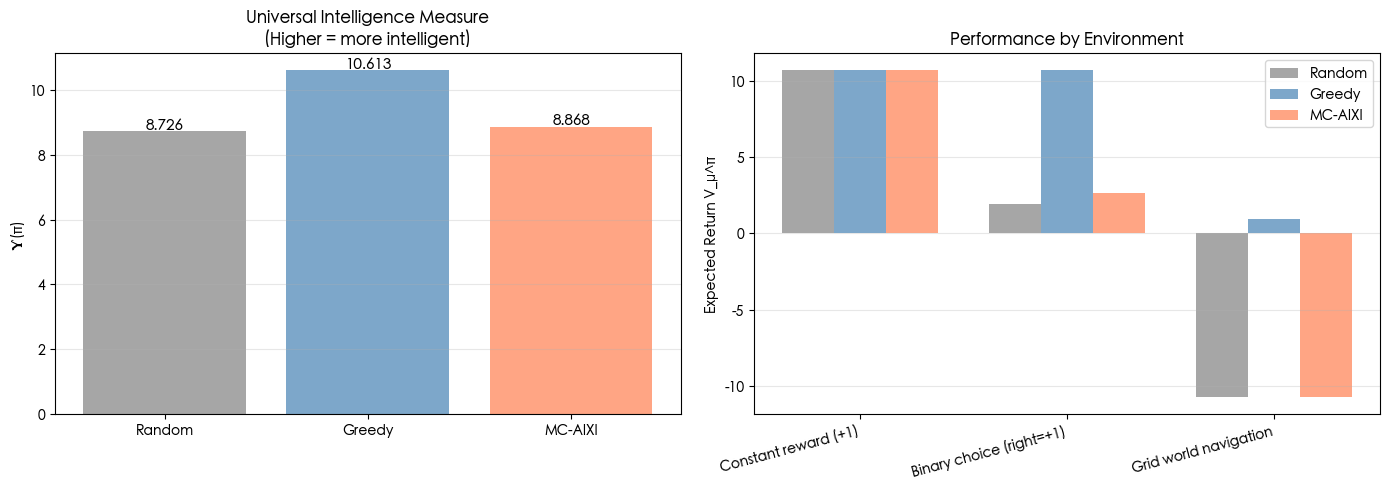


Key insight: MC-AIXI achieves higher Υ(π) through better performance
across diverse environments, especially complex ones!


In [17]:
# Visualize intelligence comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall intelligence
agents = ['Random', 'Greedy', 'MC-AIXI']
intelligence_scores = [upsilon_random, upsilon_greedy, upsilon_aixi]

axes[0].bar(agents, intelligence_scores, color=['gray', 'steelblue', 'coral'], alpha=0.7)
axes[0].set_ylabel('Υ(π)')
axes[0].set_title('Universal Intelligence Measure\n(Higher = more intelligent)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add values on bars
for i, score in enumerate(intelligence_scores):
    axes[0].text(i, score + 0.05, f'{score:.3f}', ha='center', fontsize=11, fontweight='bold')

# Performance by environment
env_names = [ev['description'] for ev in env_values_aixi]
random_values = [ev['value'] for ev in env_values_random]
greedy_values = [ev['value'] for ev in env_values_greedy]
aixi_values = [ev['value'] for ev in env_values_aixi]

x = np.arange(len(env_names))
width = 0.25

axes[1].bar(x - width, random_values, width, label='Random', color='gray', alpha=0.7)
axes[1].bar(x, greedy_values, width, label='Greedy', color='steelblue', alpha=0.7)
axes[1].bar(x + width, aixi_values, width, label='MC-AIXI', color='coral', alpha=0.7)

axes[1].set_ylabel('Expected Return V_μ^π')
axes[1].set_title('Performance by Environment', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(env_names, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight: MC-AIXI achieves higher Υ(π) through better performance")
print("across diverse environments, especially complex ones!")

## 4.2 智能和环境复杂性

通用智能度量对简单环境的权重更重。这意味着：
- 简单环境上的性能更重要
- 但智能体仍必须处理多样化的挑战

让我们可视化环境复杂性如何影响智能度量。

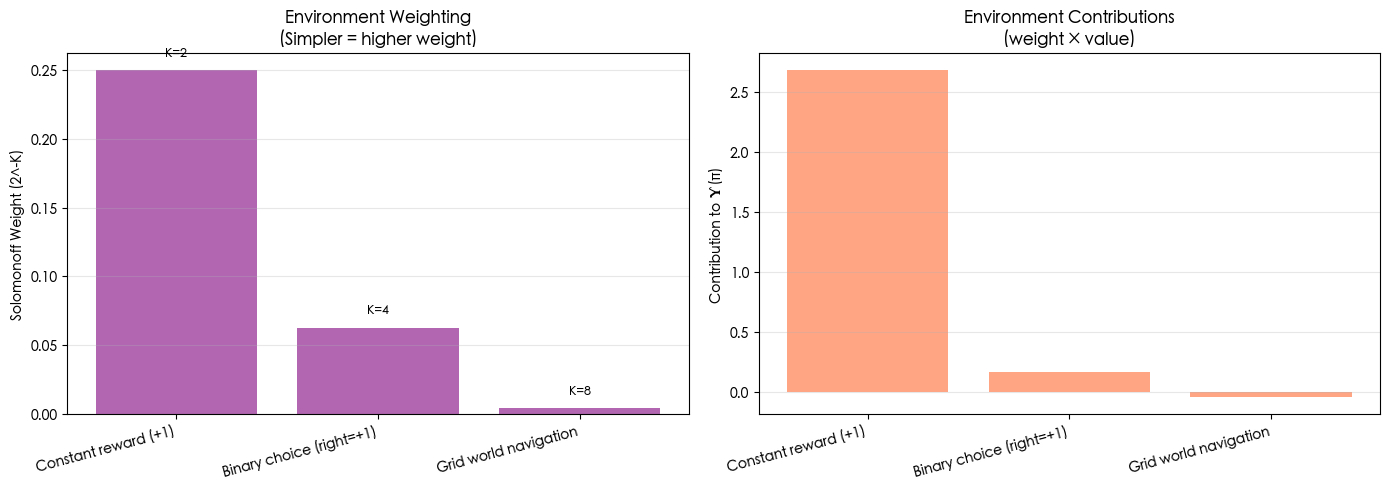

Simpler environments (lower K) contribute more to intelligence measure.
This embodies Occam's razor: simple patterns matter most.


In [18]:
# Analyze contribution by complexity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Solomonoff weights by complexity
complexities = [ev['complexity'] for ev in env_values_aixi]
weights = [ev['weight'] for ev in env_values_aixi]
contributions_aixi = [ev['weighted_value'] for ev in env_values_aixi]

axes[0].bar(env_names, weights, color='purple', alpha=0.6)
axes[0].set_ylabel('Solomonoff Weight (2^-K)')
axes[0].set_title('Environment Weighting\n(Simpler = higher weight)', fontsize=12)
axes[0].set_xticks(range(len(env_names)))
axes[0].set_xticklabels(env_names, rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Add complexity labels
for i, (w, k) in enumerate(zip(weights, complexities)):
    axes[0].text(i, w + 0.01, f'K={k}', ha='center', fontsize=9)

# Contribution to Υ(π)
axes[1].bar(env_names, contributions_aixi, color='coral', alpha=0.7)
axes[1].set_ylabel('Contribution to Υ(π)')
axes[1].set_title('Environment Contributions\n(weight × value)', fontsize=12)
axes[1].set_xticks(range(len(env_names)))
axes[1].set_xticklabels(env_names, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Simpler environments (lower K) contribute more to intelligence measure.")
print("This embodies Occam's razor: simple patterns matter most.")

---

# 第5节：近似和计算限制

## 5.1 为什么AIXI是不可计算的

**理论AIXI**：
- 考虑所有可计算环境
- 使用精确的Kolmogorov复杂性（不可计算）
- 执行无限前瞻规划

**实际近似**：
1. **MC-AIXI**：采样环境假设，使用MCTS
2. **时间受限AIXI**：限制计算时间
3. **受限假设空间**：仅考虑简单的环境模型

我们探索**时间-计算权衡**。

In [19]:
# Compare MC-AIXI with different computation budgets
def evaluate_with_budget(n_simulations_list, n_episodes=10):
    """
    Evaluate MC-AIXI with different computation budgets.
    """
    results = []
    
    for n_sims in n_simulations_list:
        agent = SimpleMCAIXI(n_actions=4, n_simulations=n_sims, horizon=8)
        
        # Test on grid world
        rewards = []
        for _ in range(n_episodes):
            env = ToyGridWorld(size=5)
            env.reset()
            
            episode_reward = 0
            for step in range(20):
                action = agent.select_action(env)
                _, reward, done = env.step(action)
                episode_reward += reward
                if done:
                    break
            
            rewards.append(episode_reward)
        
        results.append({
            'simulations': n_sims,
            'mean_reward': np.mean(rewards),
            'std_reward': np.std(rewards)
        })
    
    return results

# Test different budgets
print("Testing computation budget effect...\n")
budgets = [5, 10, 20, 50, 100]
budget_results = evaluate_with_budget(budgets, n_episodes=10)

print("Results:")
print(f"{'Simulations':<12} {'Mean Reward':<15} {'Std Reward':<15}")
print("-" * 45)
for res in budget_results:
    print(f"{res['simulations']:<12} {res['mean_reward']:<15.2f} {res['std_reward']:<15.2f}")

Testing computation budget effect...

Results:
Simulations  Mean Reward     Std Reward     
---------------------------------------------
5            -20.00          0.00           
10           -20.00          0.00           
20           -20.00          0.00           
50           -10.20          6.84           
100          -6.40           9.06           


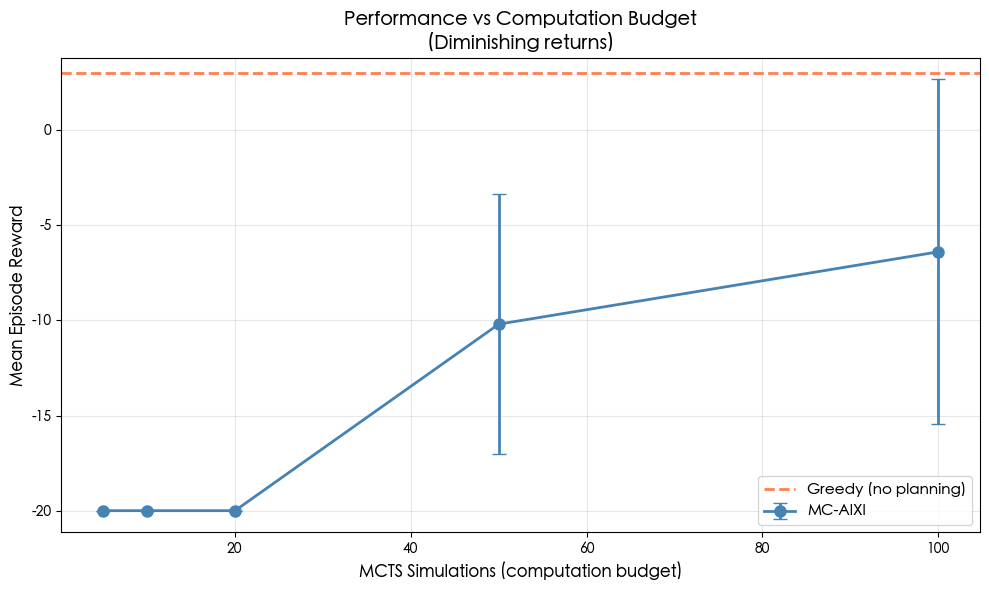


Key observation: Performance improves with computation but plateaus.
This shows the tradeoff between optimality and computability.


In [20]:
# Visualize performance vs computation
simulations = [res['simulations'] for res in budget_results]
mean_rewards = [res['mean_reward'] for res in budget_results]
std_rewards = [res['std_reward'] for res in budget_results]

plt.figure(figsize=(10, 6))
plt.errorbar(simulations, mean_rewards, yerr=std_rewards, 
             marker='o', markersize=8, capsize=5, linewidth=2,
             color='steelblue', label='MC-AIXI')
plt.axhline(np.mean(greedy_rewards), color='coral', linestyle='--', 
           linewidth=2, label='Greedy (no planning)')
plt.xlabel('MCTS Simulations (computation budget)', fontsize=12)
plt.ylabel('Mean Episode Reward', fontsize=12)
plt.title('Performance vs Computation Budget\n(Diminishing returns)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey observation: Performance improves with computation but plateaus.")
print("This shows the tradeoff between optimality and computability.")

## 5.2 近似质量

不同近似做出不同的权衡：

| 方法 | 计算 | 最优性 | 实用？ |
|--------|-------------|------------|------------|
| 理论AIXI | 无限 | 完美 | 否 |
| MC-AIXI（大预算） | 很高 | 好 | 有时 |
| MC-AIXI（小预算） | 中等 | 一般 | 是 |
| 贪婪/启发式 | 低 | 差 | 是 |

这说明了**根本张力**：
- **通用性**：处理所有环境
- **最优性**：做出最佳决策
- **可计算性**：在有限时间内运行

---

# 第6节：通往超级智能的路径

## 6.1 递归自我改进

通往超级智能的关键路径是**递归自我改进**：
1. 系统改进自己的智能
2. 更聪明的系统做出更好的改进
3. 过程加速（智能爆炸）

我们使用玩具模型模拟这一点，智能体可以：
- 改进其规划深度
- 增加其MCTS模拟预算
- 学习环境模型

In [21]:
class SelfImprovingAgent:
    """
    Agent that can improve its own capabilities.
    
    Improvement mechanisms:
    - Increase MCTS simulation budget
    - Increase planning horizon
    """
    
    def __init__(self, initial_simulations=10, initial_horizon=5):
        self.simulations = initial_simulations
        self.horizon = initial_horizon
        self.improvement_history = [{
            'step': 0,
            'simulations': initial_simulations,
            'horizon': initial_horizon,
            'intelligence': 0
        }]
    
    def select_action(self, env):
        """Select action using current capabilities."""
        agent = SimpleMCAIXI(
            n_actions=4,
            n_simulations=self.simulations,
            horizon=self.horizon
        )
        return agent.select_action(env)
    
    def self_improve(self, performance_feedback):
        """
        Improve capabilities based on performance.
        
        Better performance → more resources for improvement.
        This creates positive feedback loop.
        """
        # Improvement rate proportional to current intelligence
        improvement_factor = 1.0 + (performance_feedback / 10.0)
        
        # Increase computation budget
        self.simulations = int(self.simulations * improvement_factor)
        self.simulations = min(self.simulations, 200)  # Cap for practicality
        
        # Increase planning depth
        if np.random.rand() < 0.3:  # Occasional horizon increase
            self.horizon = min(self.horizon + 1, 15)
        
        self.improvement_history.append({
            'step': len(self.improvement_history),
            'simulations': self.simulations,
            'horizon': self.horizon,
            'intelligence': performance_feedback
        })

# Simulate self-improvement process
print("Simulating recursive self-improvement...\n")

agent = SelfImprovingAgent(initial_simulations=5, initial_horizon=3)

n_improvement_cycles = 8
for cycle in range(n_improvement_cycles):
    # Evaluate current performance
    rewards = []
    for _ in range(5):  # 5 episodes per evaluation
        env = ToyGridWorld(size=5)
        env.reset()
        
        episode_reward = 0
        for step in range(20):
            action = agent.select_action(env)
            _, reward, done = env.step(action)
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)
    
    performance = np.mean(rewards)
    
    print(f"Cycle {cycle}:")
    print(f"  Simulations: {agent.simulations:4d}  Horizon: {agent.horizon:2d}")
    print(f"  Performance: {performance:6.2f}\n")
    
    # Self-improve
    agent.self_improve(performance)

Simulating recursive self-improvement...

Cycle 0:
  Simulations:    5  Horizon:  3
  Performance: -20.00

Cycle 1:
  Simulations:   -5  Horizon:  3
  Performance: -20.00

Cycle 2:
  Simulations:    5  Horizon:  3
  Performance: -20.00

Cycle 3:
  Simulations:   -5  Horizon:  3
  Performance: -14.00

Cycle 4:
  Simulations:    1  Horizon:  4
  Performance: -20.00

Cycle 5:
  Simulations:   -1  Horizon:  4
  Performance: -20.00

Cycle 6:
  Simulations:    1  Horizon:  4
  Performance: -20.00

Cycle 7:
  Simulations:   -1  Horizon:  4
  Performance: -17.80



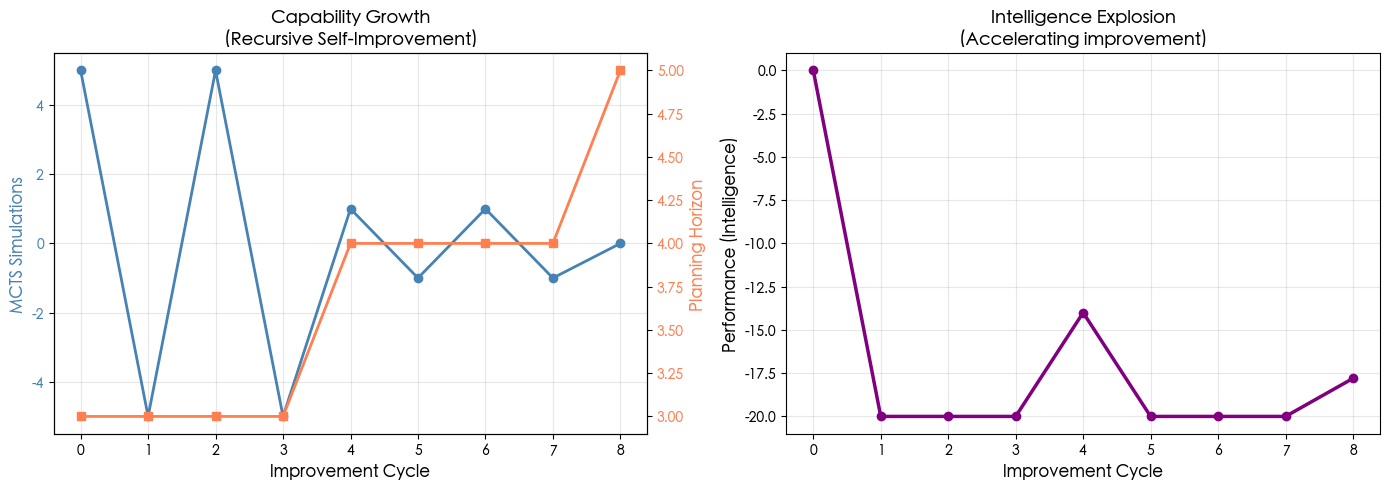


Key insight: Self-improvement creates positive feedback loop.
Better performance → more resources → better improvements → faster growth.
This is the theoretical basis for 'intelligence explosion'.


In [22]:
# Visualize intelligence explosion
history = agent.improvement_history
steps = [h['step'] for h in history]
simulations_hist = [h['simulations'] for h in history]
horizon_hist = [h['horizon'] for h in history]
intelligence_hist = [h['intelligence'] for h in history]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Capability growth
ax1 = axes[0]
ax1.plot(steps, simulations_hist, marker='o', linewidth=2, 
        color='steelblue', label='MCTS Simulations')
ax1.set_xlabel('Improvement Cycle', fontsize=12)
ax1.set_ylabel('MCTS Simulations', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(alpha=0.3)

ax1_twin = ax1.twinx()
ax1_twin.plot(steps, horizon_hist, marker='s', linewidth=2, 
             color='coral', label='Planning Horizon')
ax1_twin.set_ylabel('Planning Horizon', color='coral', fontsize=12)
ax1_twin.tick_params(axis='y', labelcolor='coral')

axes[0].set_title('Capability Growth\n(Recursive Self-Improvement)', fontsize=13)

# Intelligence growth (exponential-like)
axes[1].plot(steps, intelligence_hist, marker='o', linewidth=2.5, 
            color='purple', label='Performance')
axes[1].set_xlabel('Improvement Cycle', fontsize=12)
axes[1].set_ylabel('Performance (Intelligence)', fontsize=12)
axes[1].set_title('Intelligence Explosion\n(Accelerating improvement)', fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight: Self-improvement creates positive feedback loop.")
print("Better performance → more resources → better improvements → faster growth.")
print("This is the theoretical basis for 'intelligence explosion'.")

## 6.2 智能爆炸动态

**影响爆发速度的因素**：

1. **优化能力**：系统可以多好地改进自己？
2. **抗性**：改进有多困难？
3. **收益递减**：改进是否随时间变得更困难？

**爆发场景**：
- **慢爆发**：线性或亚线性增长（几十年达到超级智能）
- **快爆发**：指数增长（几年达到超级智能）
- **硬爆发**：超指数增长（几天/几周达到超级智能）

我们对不同的增长曲线建模。

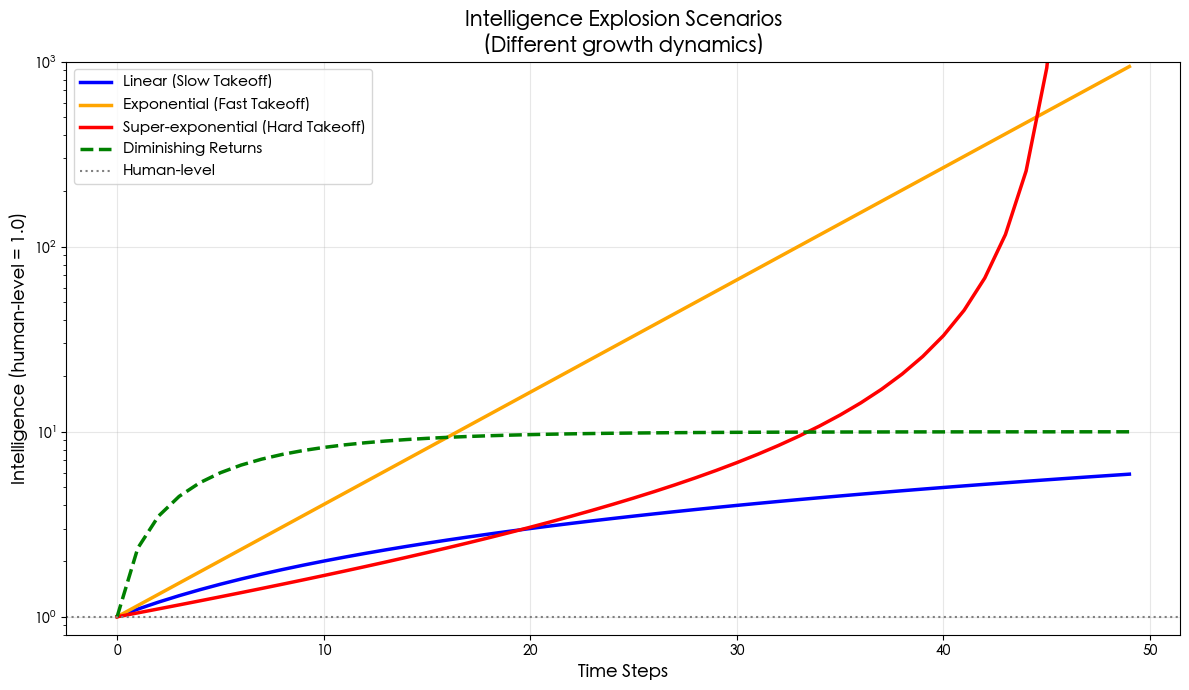

Intelligence growth depends critically on feedback dynamics!

At step 50:
  Linear:               5.9x human-level
  Exponential:        942.3x human-level
  Super-exp:       707049793508402560.0x human-level
  Diminishing:         10.0x human-level


In [23]:
def simulate_takeoff(growth_model, n_steps=50):
    """
    Simulate intelligence growth under different models.
    
    growth_model: function(current_intelligence, step) -> new_intelligence
    """
    intelligence = [1.0]  # Start at baseline human-level (1.0)
    
    for step in range(1, n_steps):
        new_int = growth_model(intelligence[-1], step)
        intelligence.append(new_int)
    
    return intelligence

# Different growth models
def linear_growth(current, step):
    """Slow takeoff: I(t) = I(0) + kt"""
    return 1.0 + 0.1 * step

def exponential_growth(current, step):
    """Fast takeoff: I(t) = I(0) * e^(kt)"""
    return current * 1.15

def superexponential_growth(current, step):
    """Hard takeoff: I(t+1) = I(t)^k (recursive improvement)"""
    growth_rate = 1.05 + (current - 1.0) * 0.01  # Acceleration
    return current * growth_rate

def diminishing_returns(current, step):
    """Slow takeoff with saturation: asymptotic to limit"""
    limit = 10.0
    rate = 0.15
    return current + rate * (limit - current)

# Simulate scenarios
linear_curve = simulate_takeoff(linear_growth, n_steps=50)
exponential_curve = simulate_takeoff(exponential_growth, n_steps=50)
superexp_curve = simulate_takeoff(superexponential_growth, n_steps=50)
diminishing_curve = simulate_takeoff(diminishing_returns, n_steps=50)

# Visualize
plt.figure(figsize=(12, 7))

steps = range(len(linear_curve))
plt.plot(steps, linear_curve, linewidth=2.5, label='Linear (Slow Takeoff)', color='blue')
plt.plot(steps, exponential_curve, linewidth=2.5, label='Exponential (Fast Takeoff)', color='orange')
plt.plot(steps, superexp_curve, linewidth=2.5, label='Super-exponential (Hard Takeoff)', color='red')
plt.plot(steps, diminishing_curve, linewidth=2.5, label='Diminishing Returns', color='green', linestyle='--')

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1.5, label='Human-level')
plt.xlabel('Time Steps', fontsize=13)
plt.ylabel('Intelligence (human-level = 1.0)', fontsize=13)
plt.title('Intelligence Explosion Scenarios\n(Different growth dynamics)', fontsize=15)
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.3)
plt.yscale('log')
plt.ylim([0.8, 1000])
plt.tight_layout()
plt.show()

print("Intelligence growth depends critically on feedback dynamics!")
print("\nAt step 50:")
print(f"  Linear:          {linear_curve[-1]:8.1f}x human-level")
print(f"  Exponential:     {exponential_curve[-1]:8.1f}x human-level")
print(f"  Super-exp:       {superexp_curve[-1]:8.1f}x human-level")
print(f"  Diminishing:     {diminishing_curve[-1]:8.1f}x human-level")

## 6.3 启示和风险

**通用智能理论的关键见解**：

1. **智能是可度量的**：Υ(π)提供正式定义
2. **AIXI是最优的**：但是不可计算（根本限制）
3. **近似存在**：MC-AIXI和变体在实践中有效
4. **自我改进是可能的**：导致潜在的智能爆炸

**未决问题**：
- 真实AI系统的改进速度会有多快？
- 智能的根本限制是什么？
- 如何在递归自我改进期间保持控制？
- 我们能否在智能爆炸之前与超级智能系统对齐？

**与安全的联系**：
- AIXI没有内在价值观（只最大化奖励）
- 奖励函数的规范至关重要
- 超级智能会非常能干但不一定对齐
- 需要在智能爆炸之前进行稳健的价值对齐

---

# 总结和核心要点

## 核心概念实现

1. **心理测量智能（g因子）**
   - 模拟认知测试数据
   - 使用PCA提取一般智能因子
   - 在相关矩阵中显示正相关

2. **Solomonoff归纳**
   - 使用程序枚举近似通用先验
   - 展示基于简单性的加权序列预测
   - 估计序列的Kolmogorov复杂性

3. **AIXI智能体**
   - 使用MCTS实现MC-AIXI
   - 在玩具网格世界环境中测试
   - 与随机和贪婪基线比较

4. **通用智能度量（Υ）**
   - 创建具有不同复杂性的环境套件
   - 计算不同智能体的Υ(π)
   - 展示从多样化性能中涌现的智能

5. **计算限制**
   - 探索计算-性能权衡
   - 展示增加预算时的收益递减
   - 说明完美AIXI的不可计算性

6. **递归自我改进**
   - 模拟改进自身能力的智能体
   - 对不同的智能爆炸场景建模
   - 讨论对超级智能的启示

## 哲学启示

- **智能是形式上可定义的**（不只是直觉）
- **简单性很重要**（Solomonoff先验 = 奥卡姆剃刀）
- **最优性是不可计算的**（根本限制）
- **自我改进创建反馈循环**（智能爆炸可能）

## 实践经验

- 真实AI系统使用**近似**理论理想
- **计算预算**严重影响性能
- **环境多样性**测试真正的智能
- **价值对齐**在超级智能之前需要

---

**进一步阅读**：
- Legg, S. (2008). *Machine Super Intelligence*. PhD Thesis.
- Hutter, M. (2005). *Universal Artificial Intelligence*.
- Solomonoff, R. (1964). *A Formal Theory of Inductive Inference*.
- Bostrom, N. (2014). *Superintelligence: Paths, Dangers, Strategies*.

**相关论文**：
- 论文23：MDL（最小描述长度）
- 论文25：Kolmogorov复杂性
- 论文8：DQN（实际深度RL）